# Neural Posterior Estimation

May the machine spirit bless me in this endeavour

In [122]:
from JHPY import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

device = torch.device('cpu')

In [123]:
# number_of_data_points = 1024

# outputs = generate_sine_data(data_points=number_of_data_points, mean=10, std=2)

# train_loader = outputs["Train_Loader"]
# val_loader = outputs["Val_Loader"]
# test_loader = outputs["Test_Loader"]

# latent_data = np.random.normal(size=number_of_data_points)

In [124]:
# just creating some random amplitudes for the time being
amplitudes = np.random.normal(10,2,20000)

train_data = torch.from_numpy(amplitudes).float().unsqueeze(1)  # Convert to float32 and add dimension

Ok so I am going to write a normalising flow BUT without the conditionality of the data for the time being, just a map between latent and amplitude space for the time being

## Coupling Layer

A lot of this next bit is from claude, going to get it working then modify

In [125]:
class CouplingLayer(nn.Module):
    """
    Affine coupling layer for normalizing flows.
    
    Given input z = [z1, z2]:
    - x1 = z1 (unchanged)
    - x2 = z2 * exp(s(z1)) + t(z1)  (transformed)
    
    where s and t are neural networks.
    """
    
    def __init__(self, dim, hidden_dim=128, mask_type='half'):
        super().__init__()
        self.dim = dim
        
        # Create mask (which dimensions to keep unchanged)
        mask = torch.zeros(dim)
        mask[:dim//2] = 1
        self.register_buffer('mask', mask)
        
        # Scale network (s)
        self.scale_net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()  # Bound output to [-1, 1], then scale
        )
        
        # Translation network (t)
        self.translate_net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, dim)
        )
        
        # Scale factor for numerical stability
        self.scale_factor = 2.0
    
    def forward(self, z):
        """
        Forward: LATENT SPACE (z) → DATA SPACE (x)
        
        Returns:
            x: transformed samples
            log_det: log determinant of Jacobian
        """
        # Apply mask to get the unchanged part
        z_masked = z * self.mask
        
        # Compute scale and translation
        s = self.scale_net(z_masked) * self.scale_factor  # Scale output
        t = self.translate_net(z_masked)
        
        # Apply transformation: x = z * exp(s) + t for masked dimensions
        x = z * self.mask + (1 - self.mask) * (z * torch.exp(s) + t)
        
        # Log determinant is sum of scales (only for transformed dimensions)
        log_det = torch.sum((1 - self.mask) * s, dim=1)
        
        return x, log_det
    
    def inverse(self, x):
        """
        Inverse: DATA SPACE (x) → LATENT SPACE (z)
        """
        x_masked = x * self.mask
        
        s = self.scale_net(x_masked) * self.scale_factor
        t = self.translate_net(x_masked)
        
        # Inverse: z = (x - t) * exp(-s) for masked dimensions
        z = x * self.mask + (1 - self.mask) * ((x - t) * torch.exp(-s))
        
        log_det = -torch.sum((1 - self.mask) * s, dim=1)
        
        return z, log_det

## Model

In [126]:
class NormalizingFlow(nn.Module):
    """
    Normalizing flow: stacks coupling layers to transform distributions.
    """
    def __init__(self, dim, n_layers=8, hidden_dim=128):
        super().__init__()
        self.dim = dim
        
        # Base distribution: standard Gaussian in LATENT SPACE
        self.register_buffer('base_mean', torch.zeros(dim))
        self.register_buffer('base_cov', torch.eye(dim))
        
        # Stack of coupling layers
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            layer = CouplingLayer(dim, hidden_dim)
            # Alternate mask every other layer
            if i % 2 == 1:
                layer.mask = 1 - layer.mask
            self.layers.append(layer)
    
    def forward(self, z):
        """
        LATENT SPACE → DATA SPACE
        Transform z (Gaussian) to x (complex distribution)
        
        Returns:
            x: samples in data space
            log_prob: log probability of samples
        """
        log_det_total = torch.zeros(z.shape[0], device=z.device)
        x = z
        
        # Apply each coupling layer
        for layer in self.layers:
            print(layer)
            x, log_det = layer(x)
            log_det_total += log_det
        
        # Compute log probability using change of variables
        # log p(x) = log p(z) + log |det(dz/dx)|
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        log_prob_base = base_dist.log_prob(z)
        log_prob = log_prob_base + log_det_total
        
        return x, log_prob
    
    def inverse(self, x):
        """
        DATA SPACE → LATENT SPACE
        Map x back to z
        """
        log_det_total = torch.zeros(x.shape[0], device=x.device)
        z = x
        
        # Apply inverse transformations in reverse order
        for layer in reversed(self.layers):
            z, log_det = layer.inverse(z)
            log_det_total += log_det
        
        return z, log_det_total
    
    def log_prob(self, x):
        """
        Compute log probability of x under the flow.
        """
        z, log_det = self.inverse(x)
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        log_prob_base = base_dist.log_prob(z)
        return log_prob_base + log_det
    
    def sample(self, n_samples):
        """
        Generate samples from the learned distribution.
        
        1. Sample z from LATENT SPACE (standard Gaussian)
        2. Transform through flow to DATA SPACE
        3. Get samples from complex distribution!
        """
        with torch.no_grad():
            base_dist = MultivariateNormal(self.base_mean, self.base_cov)
            z = base_dist.sample((n_samples,))
            x, _ = self.forward(z)
        return x

        

# Training

In [127]:
flow = NormalizingFlow(dim=1, n_layers=8, hidden_dim=128)
flow = flow.to(device)

# Optimizer
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

# Training parameters
n_epochs = 100
batch_size = 256

print("\n" + "="*70)
print("TRAINING THE NORMALIZING FLOW")
print("="*70)
print(f"\nModel parameters: {sum(p.numel() for p in flow.parameters()):,}")
print(f"Number of layers: {len(flow.layers)}")
print(f"Training samples: {len(train_data)}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {n_epochs}")

print("\nThe flow is learning to:")
print("  1. Map data space (x) BACK to latent space (z)")
print("  2. Ensure that z looks like a standard Gaussian")
print("  3. This automatically makes forward mapping (z→x) work!\n")

losses = []

for epoch in range(n_epochs):
    epoch_losses = []
    
    # Shuffle data
    perm = torch.randperm(len(train_data))
    train_data_shuffled = train_data[perm]
    
    # Mini-batch training
    for i in range(0, len(train_data), batch_size):
        batch = train_data_shuffled[i:i+batch_size].to(device)
        
        # Compute negative log likelihood
        log_prob = flow.log_prob(batch)
        loss = -log_prob.mean()  # Maximize log prob = minimize negative log prob
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(flow.parameters(), 5.0)
        
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")
print(f"  Initial loss: {losses[0]:.4f}")
print(f"  Final loss:   {losses[-1]:.4f}")
print(f"  Improvement:  {losses[0] - losses[-1]:.4f}")
print("\n" + "="*70)


TRAINING THE NORMALIZING FLOW

Model parameters: 270,352
Number of layers: 8
Training samples: 20000
Batch size: 256
Epochs: 100

The flow is learning to:
  1. Map data space (x) BACK to latent space (z)
  2. Ensure that z looks like a standard Gaussian
  3. This automatically makes forward mapping (z→x) work!



Epoch 10/100, Loss: 2.1133
Epoch 20/100, Loss: 2.1146
Epoch 30/100, Loss: 2.1082
Epoch 40/100, Loss: 2.1094
Epoch 50/100, Loss: 2.1090
Epoch 60/100, Loss: 2.1095
Epoch 70/100, Loss: 2.1096
Epoch 80/100, Loss: 2.1079
Epoch 90/100, Loss: 2.1116
Epoch 100/100, Loss: 2.1070

✓ Training complete!
  Initial loss: 2.8638
  Final loss:   2.1070
  Improvement:  0.7568



# Evaluate the distribution

CouplingLayer(
  (scale_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Tanh()
  )
  (translate_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
CouplingLayer(
  (scale_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Tanh()
  )
  (translate_net): Sequential(
    (0): Linear(in_features=

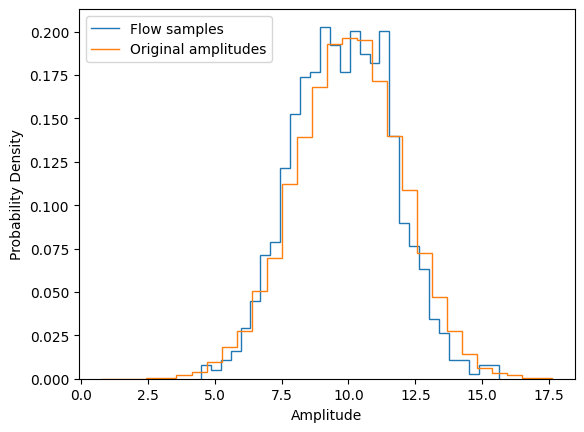

In [129]:
samples = flow.sample(1024)

# Convert histograms to stairs plots with normalization
counts1, bins1 = np.histogram(samples.detach().numpy(), bins=30, density=True)
counts2, bins2 = np.histogram(amplitudes, bins=30, density=True)

plt.stairs(counts1, bins1, label='Flow samples')
plt.stairs(counts2, bins2, label='Original amplitudes')
plt.legend()
plt.ylabel('Probability Density')
plt.xlabel('Amplitude')
plt.show()